# Facial Recognition Applied To Security
Bala, Charu, Prabhat

First part project report - link

This code is available at [https://github.com/baladutt/face].

## How To Run?
Main.ipynb is the jupyter notebook to run the project. Before running that,

* LFW dataset needs to be present in data directory. For example: data/lfw/Aaron_Eckhart/
* Download http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz into models/cnn

## Referenced Links
* https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/ * https://pypi.org/project/deepface/
* https://medium.com/@williamkoehrsen/facial-recognition-using-googles-convolutional-neural-network-5aa752b4240e * https://towardsdatascience.com/capsule-networks-the-new-deep-learning-network-bd917e6818e8

## Read Image data into memory

In [1]:
import time
import getpass
import warnings
warnings.filterwarnings('ignore')

username = getpass.getuser()
start_time = time.time()
#Where is the data?
if username == "bdutt":
    baseDir="/Users/bdutt/Documents/workspace-whitespace/face/face/data/lfw-deepfunneled"
elif username =="cgarg":
    baseDir="/Users/cgarg/Documents/charu/intuit/code/face/data/lfw"
flow = "main"
debug = False

%run "Load Data.ipynb"

filenames = []
labels = []

def collectFileNamesAndLabels(filename):
    filenames.append(filename)
    result = filename.split("/") 
    labels.append(result[len(result)-2]) #Get the label name from filename
    
doForEachFile(collectFileNamesAndLabels,baseDir, 5)
print("Total File name collection time = %s seconds" % (time.time() - start_time))
print ("Files collected : ",len(filenames))

Total File name collection time = 2.6333730220794678 seconds
Files collected :  3


In [2]:
start_time = time.time()
imagesList = []
doForEachFileNames(readImage, filenames, imagesList)
print ("Images data collected : ",len(imagesList))
print("Total data collection time = %s seconds" % (time.time() - start_time))

Images data collected :  3
Total data collection time = 0.02497696876525879 seconds


In [3]:
#%run "TransferLearningWithCNN.ipynb"

## Generic Multi threading code

Used later

In [4]:
import threading
import sys
import traceback
import time

class myThread (threading.Thread):
    def __init__(self, threadName, index, worker):
        threading.Thread.__init__(self)
        self.threadName = threadName
        self.index = index
        self.worker = worker
    def run(self):
        print('^',self.threadName, ', ', end='')
        try:
            self.worker(self.threadName, self.index)
        except:
            e = sys.exc_info()[0]
            print("Exception in thread: ",self.threadName,", ", e)
            traceback.print_exc()
        print('V',self.threadName, end='')
        

def runThreads(nThreads, worker):
    threads = []
    for i in range(nThreads):
        try:
            t = myThread("Thread-"+str(i), i , worker)
            threads.append(t)
            t.start()
        except:
            e = sys.exc_info()[0]
            print("Error: unable to start thread: ", e)
            traceback.print_exc()

    time.sleep(1)

    for t in threads:
        t.join()

In [5]:
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


Y = pd.DataFrame(labels, columns = ['name'])
sizeOfYLabel = len(Y)
oneDImageList = []
showOneImage = False

imageListLock = threading.Lock()

def flattenImage(image, imageList):
    # Convert RGB to single number
    global showOneImage
    if showOneImage:
        plt.imshow(image, cmap="Greys")
        plt.show()
    #gray = rgb2gray(image)
    gray = image
    if showOneImage:
        plt.imshow(gray, cmap="Greys")
        plt.show()
        showOneImage = False
    imageList.append(gray.flatten())

nThreads = 10
splitImagesList = np.array_split(imagesList, nThreads)
splitLabelsList = np.array_split(labels, nThreads)
labels = []

def imageFlatteningWorker(threadName, index):
    global splitImagesList
    global imageListLock
    imageList = []
    for image in splitImagesList[index]:
        flattenImage(image, imageList)
    imageListLock.acquire()
    global oneDImageList
    oneDImageList.extend(imageList)
    global labels
    labels.extend(splitLabelsList[index])
    imageListLock.release()

runThreads(nThreads, imageFlatteningWorker)
    
del imagesList

X = pd.DataFrame(oneDImageList)
del oneDImageList
print("X shape", X.shape)
print("label count", len(labels))
print("Total dataframe creation time = %s seconds" % (time.time() - start_time))

^ Thread-0 , V Thread-0^ Thread-1 , V^ Thread-1 Thread-2 , V Thread-2^ Thread-3 , V Thread-3^^ Thread-4 , V Thread-4^ Thread-6 , V Thread-6 Thread-5 , V Thread-5^^ Thread-7 , V Thread-7^ Thread-8 , V Thread-8 Thread-9 , V Thread-9X shape (3, 187500)
label count 3
Total dataframe creation time = 11.552197933197021 seconds


In [6]:
#Y['name'].value_counts()

In [7]:
start_time = time.time()
maxFrequency = 21

# We upsample/downsample to have equal quantity of all classes

#X_sample = pd.DataFrame(columns = X.columns)
#Y_sample = pd.DataFrame(columns = Y.columns)
X_sampleList = []
Y_sampleList = []

XY_sampleLock = threading.Lock()

def equalSampleLabel(label):
    global X_sampleList
    global Y_sampleList
    global XY_sampleLock
    dfa = X[Y['name']== label]
    dfasample = dfa.sample(n=maxFrequency,replace=True)
    dfb = Y[Y['name']== label]
    dfbsample = dfb.sample(n=maxFrequency,replace=True)
    print('.', end='')
    XY_sampleLock.acquire()
    print('-', end='') 
    X_sampleList.append(dfasample)
    Y_sampleList.append(dfbsample)
    XY_sampleLock.release()
    print('+', end='')



labels = Y['name'].unique()

nThreads = 10
labelsArray = np.array_split(labels, nThreads)

def worker(threadName, index):
    for label in labelsArray[index]:
        #print(threadName, label)
        equalSampleLabel(label)

runThreads(nThreads, worker)

X_sample = pd.concat(X_sampleList)
Y_sample = pd.concat(Y_sampleList)
print(X_sample.shape)
print(Y_sample.shape)
X = X_sample
Y = Y_sample
# print(X_sample)
print("Total equal sampling time = %s seconds" % (time.time() - start_time))

^ Thread-0 , ^ Thread-1 , ^ Thread-2 , ^ Thread-3 , V Thread-3^ Thread-4 , V Thread-4^^ Thread-5 , V Thread-5 Thread-6^ , V Thread-6 Thread-7 , V Thread-7^ Thread-8 , V Thread-8^ Thread-9 , V Thread-9.-+V Thread-1.-+V Thread-0.-+V Thread-2(63, 187500)
(63, 1)
Total equal sampling time = 1.1304688453674316 seconds


In [8]:
start_time = time.time()
sizeOfX = X_sample.shape[1]
#%run "DNN.ipynb"

print("Total DNN time = %s seconds" % (time.time() - start_time))

Total DNN time = 0.00010085105895996094 seconds


In [9]:
print(X_sample.shape)


(63, 187500)


In [10]:
# print(Y)
# enc.get_feature_names(['name'])
# print(enc.get_feature_names(['name']).shape)

In [11]:
# import numpy as np
# import tensorflow as tf

# Ypred = pd.DataFrame( columns = ['sampleId', "classAsIndex", "classAsString", "actualClass"])
# for i in range(300):
#     prediction = model.predict(X_sample.iloc[i:i+1,:],verbose=0)
#     class_labels = np.argmax(prediction[0], axis=0)
#     Ypred.at[i, 'sampleId']  = i
#     Ypred.at[i, 'classAsIndex']  = class_labels
#     Ypred.at[i, 'classAsString']  = enc.get_feature_names(['name'])[class_labels]
#     Ypred.at[i, 'actualClass']  = Y_sample.iloc[i].values
#     #print(class_labels, enc.get_feature_names(['name'])[class_labels]," Names of class :: ", Y_sample.iloc[i].values)

# from IPython.display import display, HTML
# display(HTML(Ypred.to_html()))

In [12]:

class_mapping = { i : labels[i] for i in range(0, len(labels) ) }
print(class_mapping)

inv_class_mapping = {v: k for k, v in class_mapping.items()}
print(inv_class_mapping)
# print(type(inv_class_mapping))
# print(inv_class_mapping['0'])

{0: 'German_Khan', 1: 'Stefano_Gabbana', 2: 'Dragan_Covic'}
{'German_Khan': 0, 'Stefano_Gabbana': 1, 'Dragan_Covic': 2}


## Invoke Inception Neural Network with Transfer Learning

In [13]:
from PIL import Image
import pandas as pd
import tensorflow as tf
print(X_sample.shape)
sample_dict = {}

X_transfer_learning = pd.DataFrame()

for ind in X_sample.index: 
    X_sample_array = X_sample.iloc[ind].as_matrix()
    arr = X_sample_array.reshape(250,250,3)
    img = tf.keras.preprocessing.image.array_to_img(arr)
    img.resize(size=(299,299), resample=Image.BICUBIC)
    array = tf.keras.preprocessing.image.img_to_array(img)
    sample_dict[0] = array
    X_transfer_learning = X_transfer_learning.append(sample_dict,ignore_index=True)

print(X_transfer_learning.shape)
print(X_transfer_learning[0][0].shape)
print(type(X_transfer_learning))
# Swap rows and columns of dataframe
# X_transfer_learning = X_transfer_learning.transpose()
# print(X_transfer_learning.shape)

(63, 187500)
(63, 1)
(250, 250, 3)
<class 'pandas.core.frame.DataFrame'>


In [14]:
label_y_sample = Y_sample.copy()
label_y_sample['name'] = label_y_sample['name'].map(inv_class_mapping)
class_images = label_y_sample['name'].value_counts()

Shape of Input to Transfer learning: X:  (63, 1) , Y:  (63, 1)
(299, 299, 3)


Using TensorFlow backend.


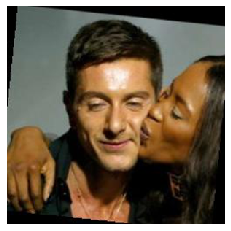

valid data shapes, X_valid:  (10143, 299, 299, 3) , y_valid:  (378,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
___________________________________________________________________________________________

Total params: 55,873,736
Trainable params: 55,813,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


Instructions for updating:
Use keras.layers.dense instead.
Done setup with n_outputs:  3
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt


In [ ]:
#print(Y_sample.shape)
#print(Y_sample)
warnings.filterwarnings('ignore')
start_time = time.time()
sizeOfX = X_sample.shape[1]
print("Shape of Input to Transfer learning: X: ", X_transfer_learning.shape, ", Y: ", Y_sample.shape)
%run "TransferLearning-New.ipynb"

print("Total transfer learning with CNN time = %s seconds" % (time.time() - start_time))